In [1]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from Parser import parse_frames
from scipy.signal import medfilt
from Functions import analyse_each_rep, find_extremas, filter_extremas, numpy_fillna, DTWDistance
from JointAngles import JointAngles
import numpy as np
import glob
import os
import pickle
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt


In [2]:
#input_folder = "C:\\Users\\altaok\\Documents\\GitHub\\IndividualProject\\keypoints_for_all\\triceps pushdown"
input_folder = 'C:\\Users\\ak5u16\\Desktop\\IndividualProject\\keypoints_for_all\\triceps_pushdown'
folder_paths = glob.glob(os.path.join(input_folder, 'triceps_pushdown*'))
points_folder_name = os.path.basename(input_folder)


def get_data_for_dataset(folder_paths, points_folder_name):
    angle_label_dict = {}
    data = {}
    # need to have a dict with keys : uf_points, ut_points, tk_points; where dict[key] = [([p], 0/1)]; append(([p], 0/1))
    #labeled_arrays = {0:[()], 1:[()]}
    angle_arrays = []
    if points_folder_name == 'triceps_pushdown': 
        for folder in folder_paths:
            video_name = os.path.basename(folder)
            label = 0 if '_correct' in folder else 1
            frame_poses = parse_frames(folder)
            joint_angles = JointAngles(points_folder_name, frame_poses)


            upArm_forearm_angles = np.array(joint_angles.upArm_forearm_angles)
            upArm_forearm_angles = np.nan_to_num(upArm_forearm_angles)
            upArm_forearm_angles_filtered = medfilt(medfilt(upArm_forearm_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_forearm_angles_filtered)

            upArm_trunk_angles = np.array(joint_angles.upArm_trunk_angles)
            upArm_trunk_angles = np.nan_to_num(upArm_trunk_angles)
            upArm_trunk_angles_filtered = medfilt(medfilt(upArm_trunk_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (upArm_trunk_angles_filtered)

            trunk_knee_angles = np.array(joint_angles.trunk_knee_angles)
            trunk_knee_angles = np.nan_to_num(trunk_knee_angles)
            trunk_knee_angles_filtered = medfilt(medfilt(trunk_knee_angles, 5), 5)
            #labeled_arrays[label][0] = labeled_arrays[label][0] + (trunk_knee_angles_filtered)

            #number of reps 
            upArm_forearm_minimas = filter_extremas(upArm_forearm_angles_filtered, find_extremas(upArm_forearm_angles_filtered, maxima=False), maxima=False) 

            angle_arrays.append((label, upArm_forearm_minimas, [upArm_forearm_angles_filtered, upArm_trunk_angles_filtered, trunk_knee_angles_filtered]))

    else: 
        print('Error: Wrong folder path! Has to be: triceps pushdown')

    return angle_arrays
                                             
                                    

def fill_dataframe(angle_arrays, exercise_folder_name):
    df_list = []
    
    print('Filling dataset with ' + str(exercise_folder_name) + ' data...')
   
    for tup in angle_arrays:
        label = tup[0]
        extremas = tup[1]
        uf_angles, ut_angles, tk_angles = tup[2]

        # Extract rep angles
        each_rep_angles = analyse_each_rep('triceps_pushdown', 'dataset', extremas, uf_angles, ut_angles, tk_angles)
        s1 = pd.Series(each_rep_angles, name='Angle_array')
        s2 = pd.Series([label for n in range(len(each_rep_angles))], name='Label')
        df = pd.concat([s1,s2], axis=1)
        df_list.append(df)

    return pd.concat(df_list).reset_index(drop=True)


        

In [3]:
angle_arrays = get_data_for_dataset(folder_paths, points_folder_name) 
df = fill_dataframe(angle_arrays, points_folder_name)
print(df.info())

Filling dataset with triceps_pushdown data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 2 columns):
Angle_array    849 non-null object
Label          849 non-null int64
dtypes: int64(1), object(1)
memory usage: 13.4+ KB
None


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print(str(df))

In [46]:
for n in df.Angle_array.values:
    for m in n:
        print(type(m))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'><class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.flo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Clustering


In [259]:
df = pickle.load( open( "datasets/triceps_df.pickle", "rb" ) )
df.head()

,Angle_array,Label
0,"[99.92144582524506, 105.98385101730454, 113.21...",0
1,"[12.492020774347218, 12.492020774347218, 12.49...",0
2,"[173.55197279771207, 173.55197279771207, 173.5...",0
3,"[94.52428256779325, 94.52428256779325, 97.5730...",0
4,"[14.41168152188108, 15.145721551859719, 15.145...",0


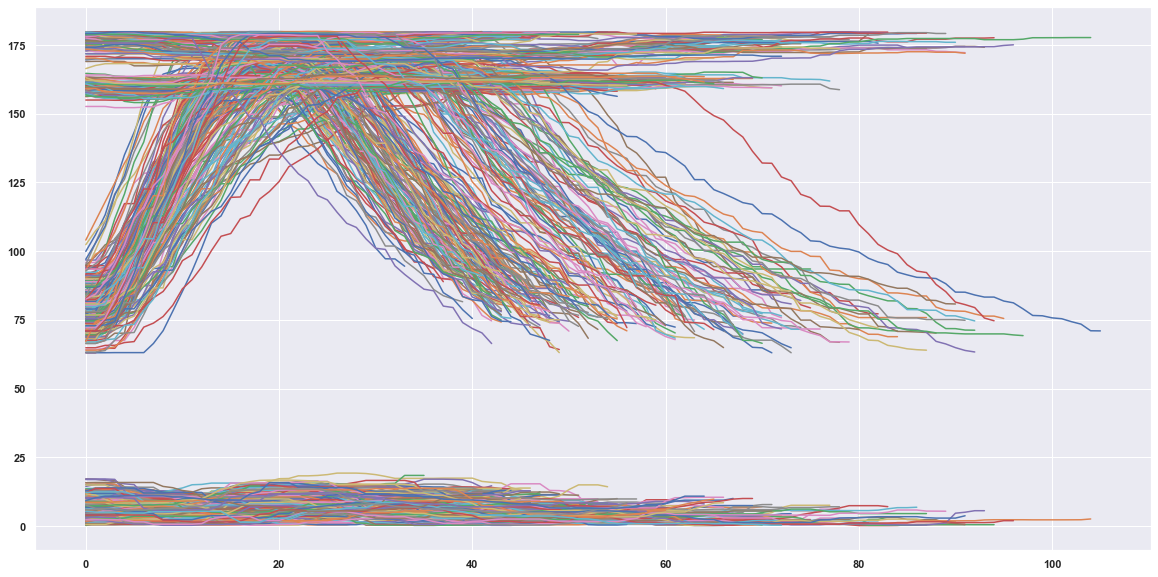

In [261]:
from dtaidistance import dtw, clustering
import seaborn as sns;sns.set()

new_df = df[df['Label'] == 0]
series = new_df.Angle_array.values.tolist()
#print(series)

#model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
#cluster_idx = model1.fit(series)
# Augment Hierarchical object to keep track of the full tree
#model2 = clustering.HierarchicalTree(model1)
#cluster_idx = model2.fit(series)
# SciPy linkage clustering
#model = clustering.LinkageTree(dtw.distance_matrix_fast, {}, method='single')
#cluster_idx = model.fit(series)

timeseries = pd.DataFrame()
ax = None
plt.figure(figsize=(20, 10))
for ts in series:
    df_ts = pd.DataFrame(ts)
    #print(df_ts.head())
    #print(df_ts.values)
    timeseries = timeseries.append(df_ts)
    #print('ye')
    ax = sns.lineplot(ax=ax,data=ts, hue='Label')

plt.show()


ValueError: setting an array element with a sequence.

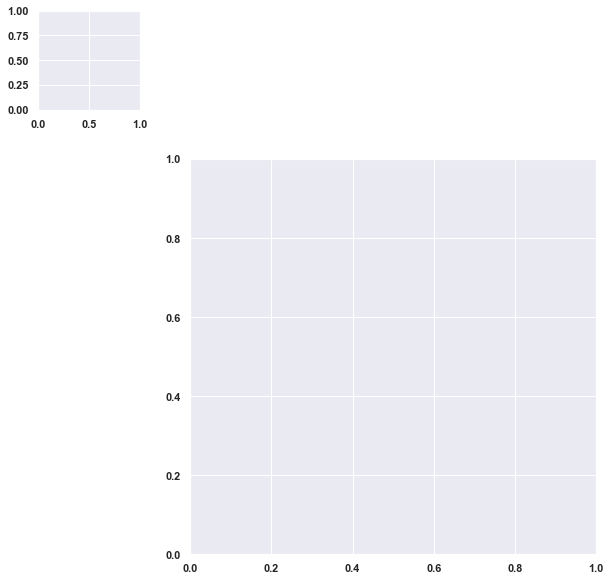

In [42]:
sns.set(color_codes=True)
g = sns.clustermap(new_df.Angle_array.values)

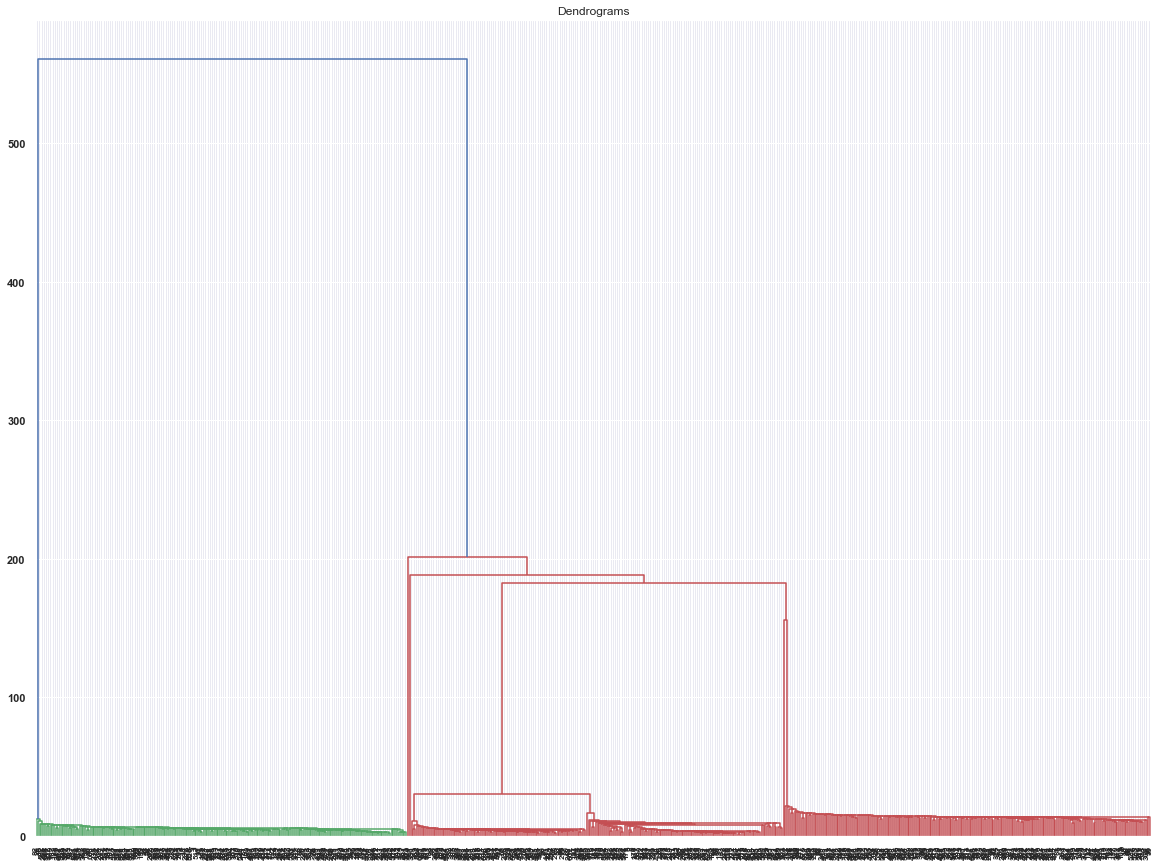

In [14]:
import scipy.cluster.hierarchy as shc
from dtaidistance import dtw, clustering
font = {'weight' : 'bold',
        'size'   : 20}
new_df = df[df['Label'] == 0]
plt.rc('font', **font)
plt.figure(figsize=(20, 15))  
plt.title("Dendrograms")  
Z = shc.linkage(numpy_fillna(new_df['Angle_array'].values),  method='single', metric=dtw.distance_fast)
dend = shc.dendrogram(Z, leaf_font_size=8.)

In [262]:
from sklearn.cluster import AgglomerativeClustering
from tslearn.utils import to_time_series_dataset


#ts_df = to_time_series_dataset(series)
#print(ts_df)

ds2 = dtw.distance_matrix_fast(series)
#print(ds2)
ds2[ds2 == np.inf] = 0
cluster = AgglomerativeClustering(n_clusters=None, affinity='precomputed', compute_full_tree=True, linkage='single', distance_threshold=182.)  
pred = cluster.fit_predict(ds2)


In [246]:
cluster.labels_.size

612

In [264]:
new_df['new_labels'] = cluster.labels_

C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [289]:
clusters = np.unique(cluster.labels_)
clusters_arrays = []
for n in clusters:
    if n!=2:
        clusters_arrays.append(np.array([np_arrs for np_arrs in new_df[new_df['new_labels'] == n].Angle_array.values]))
print(len(clusters_arrays))
for n in clusters_arrays:
    print(n.size)

3
203
204
204


In [281]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 611
Data columns (total 3 columns):
Angle_array    612 non-null object
Label          612 non-null int64
new_labels     612 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.1+ KB


In [273]:
new_df[new_df['new_labels'] == 0].head()

,Angle_array,Label,new_labels
0,"[99.92144582524506, 105.98385101730454, 113.21...",0,0
3,"[94.52428256779325, 94.52428256779325, 97.5730...",0,0
6,"[95.8773111975647, 95.8773111975647, 99.663043...",0,0
9,"[89.32800468158571, 89.32800468158571, 89.5034...",0,0
12,"[86.12571966492459, 86.12571966492459, 91.5572...",0,0


[12.49202077 12.49202077 12.49202077 12.49202077 12.49202077 13.22480165
 13.22480165 13.22480165 11.713126   10.1972427  10.1972427   9.89989849
  9.89989849  9.89989849 10.32509278 11.06168053 11.81726255 12.16347611
 12.16347611 12.16347611 12.16347611 11.8087895  11.8087895  11.8087895
 12.59549792 12.71094173 12.71094173 12.71094173 12.71094173 12.71094173
 12.73718717 12.73718717 13.25557652]


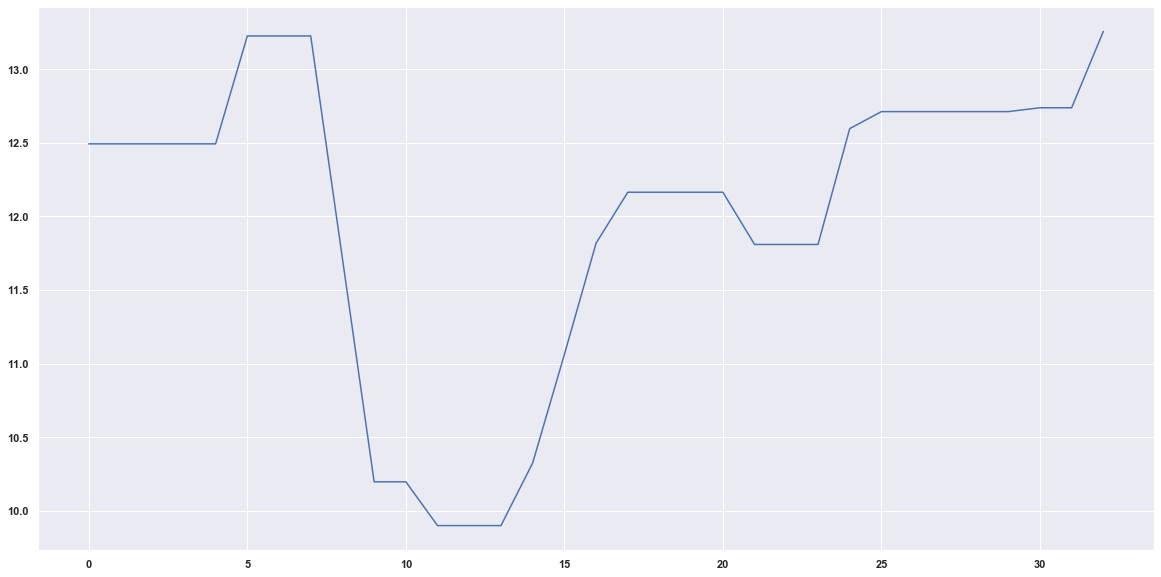

In [277]:
ax = None
plt.figure(figsize=(20, 10))
for ts in clusters_arrays[:-1]:
    print(ts)
    ax = sns.lineplot(ax=ax,data=ts)
    break

plt.show()


C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 611
Data columns (total 3 columns):
Angle_array    612 non-null object
Label          612 non-null int64
new_labels     612 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.1+ KB


In [245]:
cluster1 = pred[pred == 0]
cluster2 = pred[pred == 1]
cluster3 = pred[pred == 2]
cluster4 = pred[pred == 3]
cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
print('cluster 4 size', cluster4.size)
print('cluster 5 size', cluster5.size)

cluster 1 size 203
cluster 2 size 204
cluster 3 size 1
cluster 4 size 204
cluster 5 size 0


In [71]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

ts_df = to_time_series_dataset(new_df['Angle_array'].values)
                               
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(ts_df)
centroids = km.cluster_centers_


In [64]:
km.cluster_centers_.shape

(3, 19, 1)

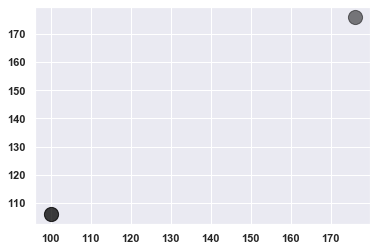

In [75]:

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


In [77]:
pred2 = km.labels_
#print(pred2)
cluster1 = pred2[pred2 == 0]
cluster2 = pred2[pred2 == 1]
cluster3 = pred2[pred2 == 2]
cluster4 = pred2[pred2 == 3]
#cluster5 = pred[pred == 4]
print('cluster 1 size', cluster1.size)
print('cluster 2 size', cluster2.size)
print('cluster 3 size', cluster3.size)
print('cluster 4 size', cluster4.size)
#print('cluster 5 size', cluster5.size)

cluster 1 size 134
cluster 2 size 478
cluster 3 size 0
cluster 4 size 0


In [101]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(ts, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='inconsistent')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    print(clusters)

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            ts.Angle_array.T.iloc[:,cluster_indeces].plot()
            plt.show()

print_clusters(new_df, Z, 1.2, plot=False)

[1]
Cluster 1 number of entries 612


In [17]:
from sklearn.model_selection import train_test_split
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

y = df['Label']
x = df['Angle_array']
#x = numpy_fillna(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(594,)
(255,)


In [18]:
k_range = range(1, 2) #26
scores = {}
scores_list = []
for k in k_range:
    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw", n_jobs=-1)
    #knn_clf = KNeighborsClassifier(k, n_jobs=-1)
    knn_clf.fit(numpy_fillna(X_train.values), y_train)
    predicted_labels = knn_clf.predict(numpy_fillna(X_test.values))
    acc = metrics.accuracy_score(y_test, predicted_labels)
    scores[k] = acc
    print("Correct classification rate:", acc)
    print('\n')
    print(metrics.classification_report(y_test, predicted_labels))
    print(metrics.f1_score(y_test, predicted_labels, average='macro'))


Correct classification rate: 0.9372549019607843


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       174
           1       0.90      0.90      0.90        81

    accuracy                           0.94       255
   macro avg       0.93      0.93      0.93       255
weighted avg       0.94      0.94      0.94       255

0.9276287782034909


In [64]:
with open('datasets/triceps_df.pickle', 'wb') as f:
    pickle.dump(df, f)